In [35]:
!pip install skillsnetwork==0.20.6
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2DTranspose, BatchNormalization, ReLU, Conv2D, LeakyReLU

from IPython import display
import skillsnetwork
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm

     ---------------------------------------- 0.0/123.9 kB ? eta -:--:--
     ----------------------------- --------- 92.2/123.9 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 123.9/123.9 kB 2.4 MB/s eta 0:00:00
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     --------------- ------------------------ 0.6/1.6 MB 19.8 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 20.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/246.1 kB ? eta -:--:--
     ------------------------------------- 246.1/246.1 kB 14.7 MB/s eta 0:00:00
  Obtaining dependency information for jsonpointer>1.13 from https://files.pythonhosted.org/packages/12/f6/0232cc0c617e195f06f810534d00b74d2f348fe71b2118009ad8ad31f878/jsonpointer-2.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for uri-template from https://files.pythonhosted.org/packages/e7/00/3fca040d7cf8a327

## Defining Helper Functions

In [36]:
# Plots five images from an array
def plot_array(X,title=""):
    
    plt.rcParams['figure.figsize'] = (20,20) 

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

## Loading the Dataset

In [42]:
# Importing the data
disco_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\disco"
electro_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\electro"
folk_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\folk"
rap_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\rap"
rock_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\rock"

# Folders to output resized images
discox64_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\discox64"
electrox64_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\electrox64"
folkx64_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\folkx64"
rapx64_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\rapx64"
rockx64_data_path = "\\Users\\kbart\\OneDrive\\Desktop\\GAN Cover Art Generator\\images labeled\\images labeled\\rockx64"


In [43]:
# Import as tf.Dataset
disco_data = tf.keras.preprocessing.image_dataset_from_directory(discox64_data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
electro_data = tf.keras.preprocessing.image_dataset_from_directory(electrox64_data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
folk_data = tf.keras.preprocessing.image_dataset_from_directory(folkx64_data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
rap_data = tf.keras.preprocessing.image_dataset_from_directory(rapx64_data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
rock_data = tf.keras.preprocessing.image_dataset_from_directory(rockx64_data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 1783 files belonging to 1 classes.
Found 1864 files belonging to 1 classes.
Found 1900 files belonging to 1 classes.
Found 1853 files belonging to 1 classes.
Found 1911 files belonging to 1 classes.


In [45]:
# Concatenate all the datasets into one class
all_song_data = disco_data.concatenate(electro_data).concatenate(folk_data).concatenate(rap_data).concatenate(rock_data)

# Shuffle and prefetch the dataset for training optimization (optional)
all_song_data = all_song_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Creating Data Generator

In [37]:
# Declare image properties
img_height, img_width, batch_size=64,64,128

In [47]:
# nomalize the pixwl values of al the input images from [0,255] to [-1,1]
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = all_song_data.map(lambda x: normalization_layer(x))

In [49]:
images = all_song_data.take(1)

In [50]:
X = [x for x in images]

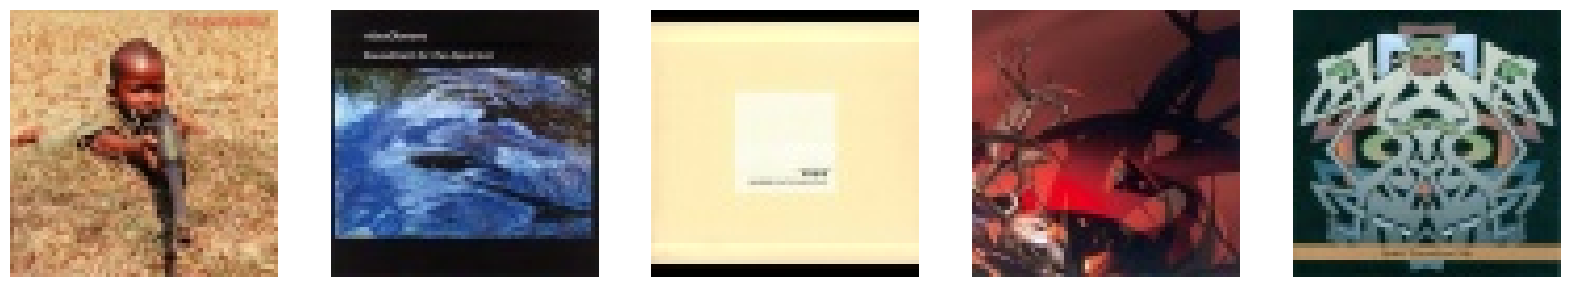

In [51]:
plot_array(X[0])

## Generator and Discriminator

In [52]:
def make_generator():
    
    model=Sequential()
    
    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))
    
    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))

                       
    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, 
                              activation='tanh', name='conv_transpose_5'))

    return model

In [53]:
gen = make_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 512)         0         
                                                                 
 conv_transpose_2 (Conv2DTr  (None, 8, 8, 256)         2097152   
 anspose)                                                        
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)         0

In [54]:
def make_discriminator():
    
    model=Sequential()
    
    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,  
                     activation='sigmoid', name='conv_5'))

    return model 

disc = make_discriminator()
disc.summary()

## Defining Loss Function

In [56]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [57]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [58]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Defining Optimizers

In [59]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Create Train Step Function

In [60]:
@tf.function

def train_step(X):
    
    #random samples it was found if you increase the  stander deviation, you get better results 
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)
        
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

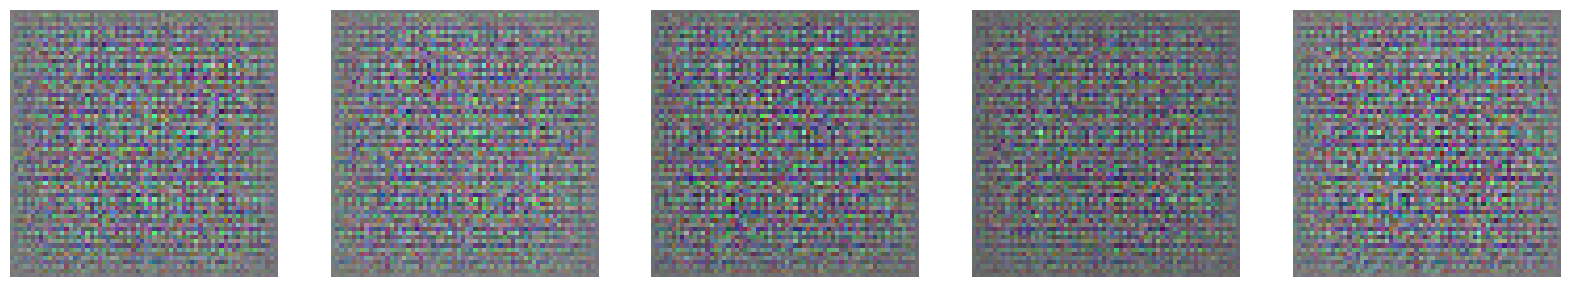

In [61]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Training the Model

epoch 1:   0%|          | 0/147 [00:00<?, ?it/s]

epoch 1, iteration 1
epoch 1, iteration 2
epoch 1, iteration 3
epoch 1, iteration 4
epoch 1, iteration 5
epoch 1, iteration 6
epoch 1, iteration 7
epoch 1, iteration 8
epoch 1, iteration 9
epoch 1, iteration 10
epoch 1, iteration 11
epoch 1, iteration 12
epoch 1, iteration 13
epoch 1, iteration 14
epoch 1, iteration 15
epoch 1, iteration 16
epoch 1, iteration 17
epoch 1, iteration 18
epoch 1, iteration 19
epoch 1, iteration 20
epoch 1, iteration 21
epoch 1, iteration 22
epoch 1, iteration 23
epoch 1, iteration 24
epoch 1, iteration 25
epoch 1, iteration 26
epoch 1, iteration 27
epoch 1, iteration 28
epoch 1, iteration 29
epoch 1, iteration 30
epoch 1, iteration 31
epoch 1, iteration 32
epoch 1, iteration 33
epoch 1, iteration 34
epoch 1, iteration 35
epoch 1, iteration 36
epoch 1, iteration 37
epoch 1, iteration 38
epoch 1, iteration 39
epoch 1, iteration 40
epoch 1, iteration 41
epoch 1, iteration 42
epoch 1, iteration 43
epoch 1, iteration 44
epoch 1, iteration 45
epoch 1, iteration 

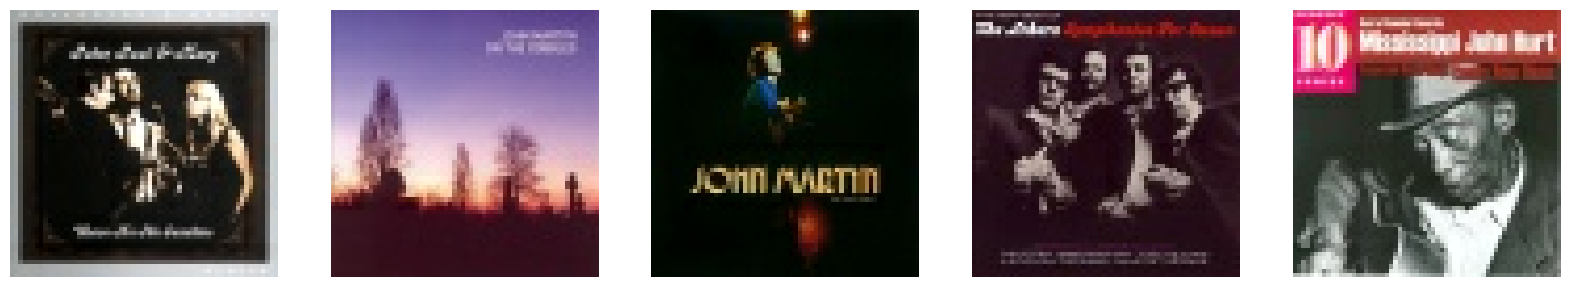

generated images


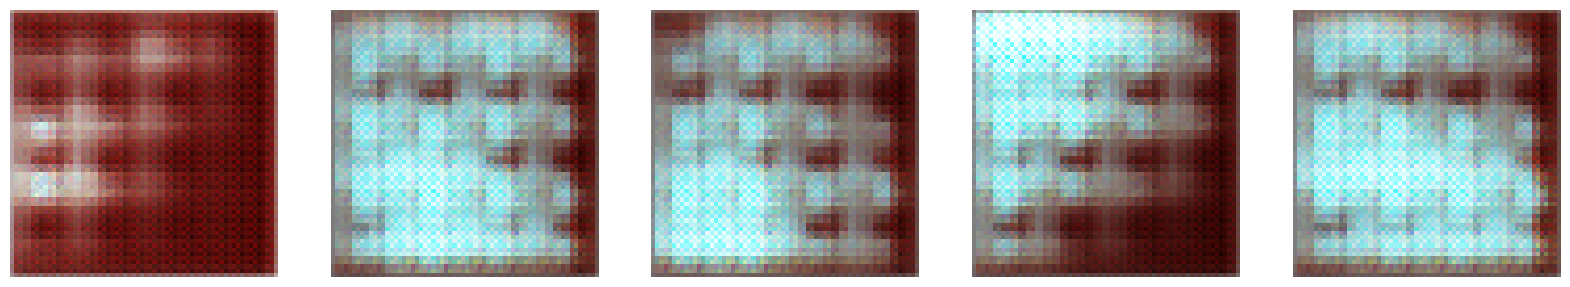

Time for epoch 1 is 682.2687964439392 sec


In [62]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):
    
    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        
        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))
            
        train_step(X)
    

    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))